In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb
import warnings
import corner

## PHYS 512 - Problem Set 2
Tristan Ménard<br>
260675783
### Problem 1

In [2]:
# Import the data
data = np.loadtxt('WMAP_9yr_combined_power_spectrum.txt')
multipole = data[:,0]
power_spectrum = data[:,1]
err = data[:,2]

In [3]:
def get_spectrum(pars, lmax=2000):
    """
    Returns a model for the TT power spectrum according to the input parameters using the camb package.
    The input parameters are:
        H0 = Hubble constant
        ombh2 = physical baryon density
        omch2 = cold dark matter density
        tau = optical depth
        As = primordial amplitude of fluctuations
        ns = slope of the primordial power law
    """
    H0, ombh2, omch2, tau, As, ns = pars
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=0.06, tau=tau)
    pars.InitPower.set_params(As=As, ns=ns, r=0)
    pars.set_for_lmax(lmax, lens_potential_accuracy=0)
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    cmb = powers['total']
    tt = cmb[:,0]
    return tt

In [4]:
# Give parameters
pars = [65, 0.02, 0.1, 0.05, 2e-9, 0.96] # [H0, ombh2, omch2, tau, As, ns]
# Compute the TT power spectrum model for these parameters
cmb = get_spectrum(pars, 1199)
cmb_cut = cmb[2:] # keep only the CMB model for the multipole moments which are in the data (l = 2 to 1200)

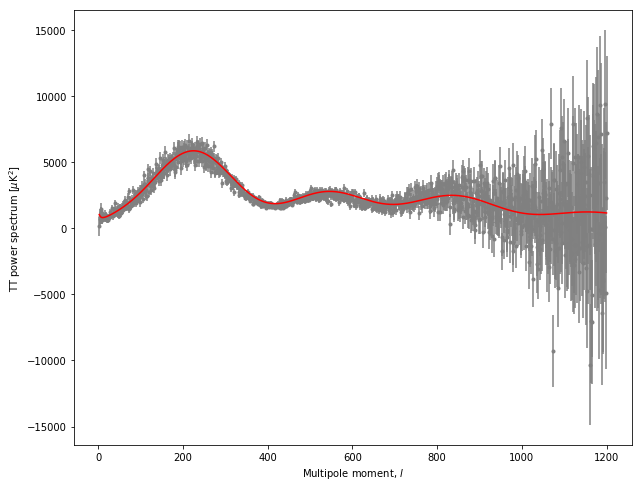

In [5]:
# Overplot the data points with the computed TT power spectrum model
plt.figure(figsize=(10,8))
plt.errorbar(multipole, power_spectrum, yerr=err, fmt='.', color='grey', barsabove=True)
plt.plot(multipole, cmb_cut, 'r')
plt.xlabel(r'Multipole moment, $l$')
plt.ylabel(r'TT power spectrum [$\mu$K$^2$]')
plt.show()

Assuming uncorrelated gaussian errors, $\chi^2$ can be calculated using the following formula:
$$\chi^2 = \sum_i \left(\frac{y_{\text{data},i} - y_{\text{model},i}}{\sigma_i}\right)^2$$

In [6]:
# Calculate chi-squared
resid = power_spectrum - cmb_cut
chisq = np.sum((resid/err)**2)
print('Chi-squared = '+repr(chisq))

Chi-squared = 1588.4366720631901


### Problem 2

The derivatives of the power spectrum with respect to the fit parameters must be calculated numerically. One of the easiest ways to do this is to use a double-sided derivative approximation.

$$ \frac{d}{dx} f(x,y) \approx \frac{f(x+\delta,y)-f(x-\delta,y))}{2\delta}$$

In [7]:
def get_spectrum_derivs(pars, delta, lmax=1199):
    """
    Returns the model and derivatives of the model w.r.t. H0, ombh2, omch2, As, and ns.
    The derivatives are estimated using the numerical double-sided derivative approximation technique.
    """
    # Parse input parameters
    H0, ombh2, omch2, As, ns = pars
    tau = 0.05
    # Parse deltas
    delta1, delta2, delta3, delta4, delta5 = delta
    # Compute the model
    ref = get_spectrum([H0, ombh2, omch2, tau, As, ns], lmax)
    # Compute the derivatives w.r.t. each fit parameter with Newton's method for estimating numerical derivatives
    dH0 = (get_spectrum([H0+delta1,ombh2,omch2,tau,As,ns],lmax)-get_spectrum([H0-delta1,ombh2,omch2,tau,As,ns],lmax))/(2*delta1)
    dombh2 = (get_spectrum([H0,ombh2+delta2,omch2,tau,As,ns],lmax)-get_spectrum([H0,ombh2-delta2,omch2,tau,As,ns],lmax))/(2*delta2)
    domch2 = (get_spectrum([H0,ombh2,omch2+delta3,tau,As,ns],lmax)-get_spectrum([H0,ombh2,omch2-delta3,tau,As,ns],lmax))/(2*delta3)
    dAs = (get_spectrum([H0,ombh2,omch2,tau,As+delta4,ns],lmax)-get_spectrum([H0,ombh2,omch2,tau,As-delta4,ns],lmax))/(2*delta4)
    dns = (get_spectrum([H0,ombh2,omch2,tau,As,ns+delta5],lmax)-get_spectrum([H0,ombh2,omch2,tau,As,ns-delta5],lmax))/(2*delta5)
    # Cut off the first two values in the model and derivatives because multipoles moments of 0 and 1 are not relevant
    fun = ref[2:]
    # Organize the derivatives in an array
    derivs = np.zeros([lmax, len(pars)])
    derivs[:,0] = dH0[2:]
    derivs[:,1] = dombh2[2:]
    derivs[:,2] = domch2[2:]
    derivs[:,3] = dAs[2:]
    derivs[:,4] = dns[2:]
    return fun, derivs

In [8]:
def update_lmbda(lmbda, success):
    """
    Return an updated lambda value for the Levenberg-Marquandt technique depending on the success of the previous step.
    If the previous step failed and lambda=0, then update it to 1.
    If the previous step failed and lambda = anything else, double lambda.
    If the previous step 
    """
    if success == False:
        if lmbda == 0:
            lmbda = 1
        else:
            lmbda = 2*lmbda
    else:
        if lmbda < 0.2:
            lmbda = 0
        else:
            lmbda = lmbda/np.sqrt(5)
    return lmbda

In [9]:
# Levenber-Marquardt procedure:
pars = [65, 0.02, 0.1, 2e-9, 0.96] # H0, ombh2, omch2, As, ns
deltas = [0.1, 1e-4, 1e-3, 1e-11, 1e-3] # step sizes to use in the derivative approximation
cmb, derivs = get_spectrum_derivs(pars, deltas)

lmbda = 0
chisq_threshold = 0.01
Ninv = np.linalg.inv(np.diag(err))
resid = power_spectrum - cmb
chisq = np.sum((resid/err)**2)
print('Initial guess: chi-squared = '+repr(chisq))

chisq_accepted = [chisq] # holds all accepted chi-squared values

for i in range(8):
    rhs = np.dot(derivs.transpose(), np.dot(Ninv, resid))
    lhs = np.dot(derivs.transpose(), np.dot(Ninv, derivs))
    lhs = lhs + lmbda*np.diag(np.diag(lhs))
    new_cov = np.linalg.inv(lhs) # covariance matrix = inverse of curvature matrix
    new_pars = pars + np.dot(new_cov, rhs)
    new_cmb, new_derivs = get_spectrum_derivs(new_pars, deltas)
    new_resid = power_spectrum - new_cmb
    new_chisq = np.sum((new_resid/err)**2)
    delta_chisq = new_chisq - chisq
    print('Step '+repr(i+1)+': chi-squared change = '+repr(delta_chisq))
    
    if new_chisq <= chisq:
        resid = new_resid
        chisq = new_chisq
        derivs = new_derivs
        pars = new_pars
        cov = new_cov
        lmbda = update_lmbda(lmbda, success=True)
        print('Updating lambda to '+repr(lmbda)+'.')
        
        chisq_accepted.append(new_chisq) # hold on to the accepted chi-squared values
        
        # Stop iterative process once the solution has converged below the chi-squared threshold
        if lmbda == 0 and np.abs(delta_chisq) < chisq_threshold and i > 0:
            print('Stopping after '+repr(i+1)+' iterations.')
            break
    else:
        lmbda = update_lmbda(lmbda, success=False)
        print('Reject! Updating lambda to '+repr(lmbda)+'.')

Initial guess: chi-squared = 1588.4366720631901
Step 1: chi-squared change = -349.6073215332558
Updating lambda to 0.
Step 2: chi-squared change = -9.894941234577345
Updating lambda to 0.
Step 3: chi-squared change = -0.028824694128616102
Updating lambda to 0.
Step 4: chi-squared change = -0.004233805589592521
Updating lambda to 0.
Stopping after 4 iterations.


L-M optimized fit chi-squared = 1228.9013507956388
Best-fit parameters are:
H0 = 67.84922587748973 +/- 0.13669155613892997
ombh2 = 0.022472686684915057 +/- 3.06942174901287e-05
omch2 = 0.11640578004372466 +/- 0.0002876339830775752
As = 2.0606673563439513e-09 +/- 1.8994440623600164e-12
ns = 0.9685479665535844 +/- 0.000804304262777316


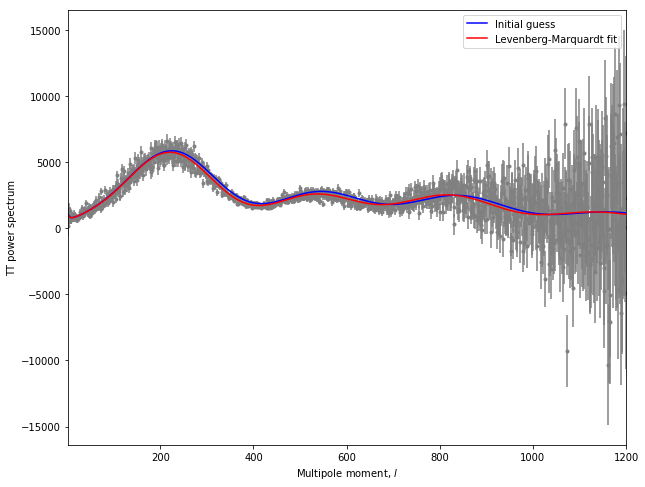

In [10]:
# Print chi-squared obtained from the Levenberg-Marquardt best fit
print('L-M optimized fit chi-squared = '+repr(chisq))

# Print the error on each fit parameter obtained from the diagonal elements of the covariance matrix
print('Best-fit parameters are:')
print('H0 = '+repr(pars[0])+' +/- '+repr(np.sqrt(np.diag(cov)[0])))
print('ombh2 = '+repr(pars[1])+' +/- '+repr(np.sqrt(np.diag(cov)[1])))
print('omch2 = '+repr(pars[2])+' +/- '+repr(np.sqrt(np.diag(cov)[2])))
print('As = '+repr(pars[3])+' +/- '+repr(np.sqrt(np.diag(cov)[3])))
print('ns = '+repr(pars[4])+' +/- '+repr(np.sqrt(np.diag(cov)[4])))

# Overplot the power spectrum data with the initial guess model and the Levenberg-Marquardt fit model
plt.figure(figsize=(10,8))
plt.errorbar(multipole, power_spectrum, yerr=err, fmt='.', color='gray', barsabove=True)
plt.plot(multipole, cmb, 'b', label='Initial guess')
plt.plot(multipole, new_cmb, 'r', label='Levenberg-Marquardt fit')
plt.xlabel(r'Multipole moment, $l$')
plt.ylabel('TT power spectrum')
plt.xlim(2,1200)
plt.legend()
plt.show()

I can plot the $\chi^2$ for the accepted steps in the Levenberg-Marquardt fitting process. The below plot shows how the $\chi^2$ converges rapidly to around 1228. The stable convergence signifies that the derivative estimates from earlier are believable.

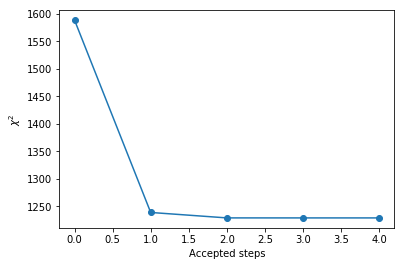

In [11]:
plt.plot(chisq_accepted, 'o-')
plt.ylabel(r'$\chi^2$')
plt.xlabel('Accepted steps')
plt.show()

If I were to keep the same set of parameters but float the optical depth, I would expect the new errors to be larger as another degree of freedom and complexity is added to the problem. Let's check this assumption:

In [12]:
# Find the errors when tau is allowed to float and keep the current best fit parameters.
H0, ombh2, omch2, As, ns = pars
tau = 0.05
npar = len(pars)+1

# The covariance matrix was calculated for a fixed optical depth earlier. Now we want it for a free tau variable
# Get the derivatives (including the derivative w.r.t tau)
lmax = 1199
delta1, delta2, delta3, delta4, delta5, delta6 = [0.1, 1e-4, 1e-3, 1e-4, 1e-11, 1e-3]

dH0 = (get_spectrum([H0+delta1,ombh2,omch2,tau,As,ns],lmax)-get_spectrum([H0-delta1,ombh2,omch2,tau,As,ns],lmax))/(2*delta1)
dombh2 = (get_spectrum([H0,ombh2+delta2,omch2,tau,As,ns],lmax)-get_spectrum([H0,ombh2-delta2,omch2,tau,As,ns],lmax))/(2*delta2)
domch2 = (get_spectrum([H0,ombh2,omch2+delta3,tau,As,ns],lmax)-get_spectrum([H0,ombh2,omch2-delta3,tau,As,ns],lmax))/(2*delta3)
dtau = (get_spectrum([H0,ombh2,omch2,tau+delta4,As,ns],lmax)-get_spectrum([H0,ombh2,omch2,tau-delta4,As,ns],lmax))/(2*delta4)
dAs = (get_spectrum([H0,ombh2,omch2,tau,As+delta5,ns],lmax)-get_spectrum([H0,ombh2,omch2,tau,As-delta5,ns],lmax))/(2*delta5)
dns = (get_spectrum([H0,ombh2,omch2,tau,As,ns+delta6],lmax)-get_spectrum([H0,ombh2,omch2,tau,As,ns-delta6],lmax))/(2*delta6)
# Organize the derivatives in an array. Cut off the first two values because multipole moments 0 and 1 are irrelevant to the dataset
derivs = np.zeros([lmax, npar])
derivs[:,0] = dH0[2:]
derivs[:,1] = dombh2[2:]
derivs[:,2] = domch2[2:]
derivs[:,3] = dtau[2:]
derivs[:,4] = dAs[2:]
derivs[:,5] = dns[2:]

# Use the derivatives to calculate the covariance matrix
Ninv = np.linalg.inv(np.diag(err))
lhs = np.dot(derivs.transpose(), np.dot(Ninv, derivs))
mycov = np.linalg.inv(lhs)

# Print the covariance matrix and the new errors
print('For free tau:')
print('Covariance matrix = ', mycov)
print('Best-fit parameters are now:')
print('H0 = '+repr(H0)+' +/- '+repr(np.sqrt(np.diag(mycov)[0])))
print('ombh2 = '+repr(ombh2)+' +/- '+repr(np.sqrt(np.diag(mycov)[1])))
print('omch2 = '+repr(omch2)+' +/- '+repr(np.sqrt(np.diag(mycov)[2])))
print('tau = '+repr(tau)+' +/- '+repr(np.sqrt(np.diag(mycov)[3])))
print('As = '+repr(As)+' +/- '+repr(np.sqrt(np.diag(mycov)[4])))
print('ns = '+repr(ns)+' +/- '+repr(np.sqrt(np.diag(mycov)[5])))

For free tau:
Covariance matrix =  [[ 3.68857931e-02  6.87185393e-06 -6.71364341e-05  9.37578822e-04
   3.55372278e-12  2.35201179e-04]
 [ 6.87185393e-06  1.95486117e-09 -1.04463268e-08  2.21172365e-07
   8.76593782e-16  5.47514971e-08]
 [-6.71364341e-05 -1.04463268e-08  1.39739070e-07 -1.65942657e-06
  -6.11420320e-15 -4.03538187e-07]
 [ 9.37578822e-04  2.21172365e-07 -1.65942657e-06  4.83060987e-05
   1.92566038e-13  7.60665119e-06]
 [ 3.55372278e-12  8.76593782e-16 -6.11420320e-15  1.92566038e-13
   7.71247607e-22  2.98448922e-14]
 [ 2.35201179e-04  5.47514971e-08 -4.03538187e-07  7.60665119e-06
   2.98448922e-14  1.84478065e-06]]
Best-fit parameters are now:
H0 = 67.84922587748973 +/- 0.1920567445821537
ombh2 = 0.022472686684915057 +/- 4.4213811950476185e-05
omch2 = 0.11640578004372466 +/- 0.0003738168936621758
tau = 0.05 +/- 0.006950258897782247
As = 2.0606673563439513e-09 +/- 2.777134506961022e-11
ns = 0.9685479665535844 +/- 0.0013582270255833888


So, yes, the errors did indeed increase.

### Problem 3

In [13]:
def take_step_cov(covmat):
    mychol = np.linalg.cholesky(covmat)
    return np.dot(mychol, np.random.randn(covmat.shape[0]))

In [14]:
# Handle warnings as errors for following MCMC
warnings.filterwarnings('error')

In [17]:
# Start with some initial parameters for the model
params = [65, 0.02, 0.1, 0.05, 2e-9, 0.96]

# Compute the power spectrum model with these initial parameters
model_0 = get_spectrum(params, lmax)[2:]

# Calculate the chi-squared and setup the MCMC fitting procedure
chisq = np.sum(((power_spectrum - model_0)/err)**2)

nstep = 2000
chains = np.zeros([nstep, len(params)])
chisqvec = np.zeros(nstep)
scale_fac = 3.0 # gives an acceptance ratio of ~35%

c = 0
with open('logfile5.txt', 'w') as f:
    f.write('Step\tH0\t\t\t\t\tombh2\t\t\t\tomch2\t\t\t\ttau\t\t\t\t\tAs\t\t\t\t\tns\t\t\t\t\tNewChi2\t\t\t\tDeltaChi2\t\t\tProb\t\t\t\tAccept\n')
    while c < nstep:
        # Sample a new set of parameters using the covariance matrix from 2 for a free tau
        new_params = params + take_step_cov(mycov)*scale_fac
        # If a negative tau is sampled, resample.
        if new_params[3] < 0:
            continue
        try:
            new_model = get_spectrum(new_params, lmax)[2:]
            new_chisq = np.sum(((power_spectrum-new_model)/err)**2)
            delta_chisq = new_chisq - chisq
            prob = np.exp(-delta_chisq/2)
            accept = np.random.rand() < prob
            if accept:
                f.write('{:00005d}\t{:.10e}\t{:.10e}\t{:.10e}\t{:.10e}\t{:.10e}\t{:.10e}\t{:.10e}\t{:.10e}\t{:.10e}\t{:d}\n'.format(c+1,new_params[0],new_params[1],new_params[2],new_params[3],new_params[4],new_params[5],new_chisq,delta_chisq,prob,1))
                params = new_params
                model = new_model
                chisq = new_chisq
            else:
                f.write('{:00005d}\t{:.10e}\t{:.10e}\t{:.10e}\t{:.10e}\t{:.10e}\t{:.10e}\t{:.10e}\t{:.10e}\t{:.10e}\t{:d}\n'.format(c+1,new_params[0],new_params[1],new_params[2],new_params[3],new_params[4],new_params[5],new_chisq,delta_chisq,prob,0))
            chains[c,:] = params
            chisqvec[c] = chisq
            c = c + 1
            f.flush()
        except:
            continue

Final chi-squared = 1232.3453801866394


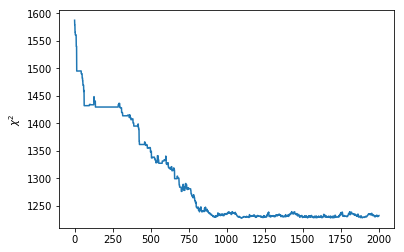

In [18]:
# Take a look at the chi-squared evolution
print('Final chi-squared = '+repr(chisqvec[-1]))
plt.plot(chisqvec)
plt.ylabel(r'$\chi^2$')
plt.show()

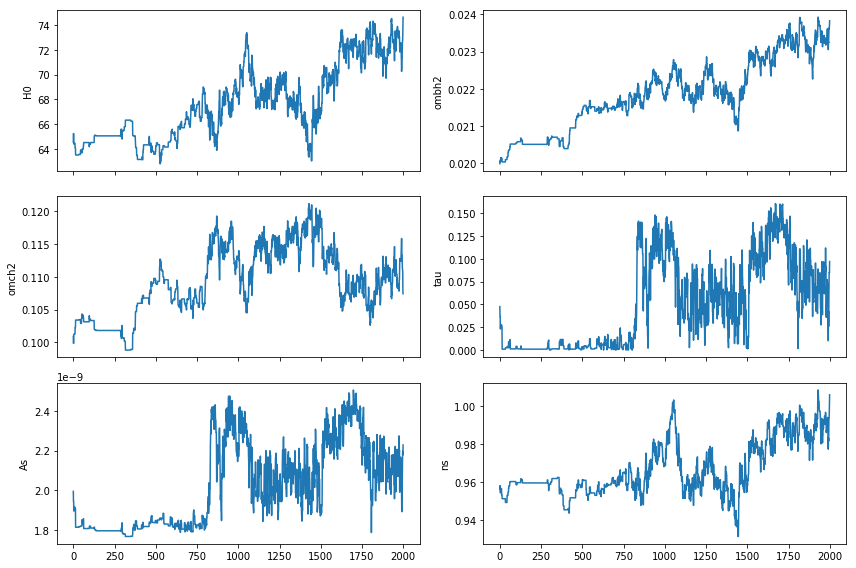

In [19]:
# Take a look at the Markov chain
f, axes = plt.subplots(3, 2, sharex=True, figsize=(12,8))

axes[0,0].plot(chains[:,0])
axes[0,1].plot(chains[:,1])
axes[1,0].plot(chains[:,2])
axes[1,1].plot(chains[:,3])
axes[2,0].plot(chains[:,4])
axes[2,1].plot(chains[:,5])

axes[0,0].set_ylabel('H0')
axes[0,1].set_ylabel('ombh2')
axes[1,0].set_ylabel('omch2')
axes[1,1].set_ylabel('tau')
axes[2,0].set_ylabel('As')
axes[2,1].set_ylabel('ns')
plt.tight_layout()
plt.show()

Clearly, the parameters are not converged. If a parameter is converged, it's Markov chain should look like white noise, which is not the case here. We would likely need to use more steps to get a converged result. Additionally, it is important to note that tau and As are stongly correlated! Nonetheless, I can get results and errors for the parameter values from the mean and standard deviation of the Markov chain. Since the $\chi^2$ was still converging to a minimum for the first ~1000 samples, I will exclude those samples from the mean and standard deviation evaluation.

In [54]:
n = 1000
print('H0 = '+repr(np.mean(chains[n:,0]))+' +/- '+repr(np.std(chains[n:,0])))
print('ombh2 = '+repr(np.mean(chains[n:,1]))+' +/- '+repr(np.std(chains[n:,1])))
print('omch2 = '+repr(np.mean(chains[n:,2]))+' +/- '+repr(np.std(chains[n:,2])))
print('tau = '+repr(np.mean(chains[n:,3]))+' +/- '+repr(np.std(chains[n:,3])))
print('As = '+repr(np.mean(chains[n:,4]))+' +/- '+repr(np.std(chains[n:,4])))
print('ns = '+repr(np.mean(chains[n:,5]))+' +/- '+repr(np.std(chains[n:,5])))

H0 = 69.96260000590637 +/- 2.4630306174670555
ombh2 = 0.022569073298318636 +/- 0.0006762742114491562
omch2 = 0.11204866752847656 +/- 0.003961813946310381
tau = 0.07909518092799328 +/- 0.03822379990969621
As = 2.1540496091254233e-09 +/- 1.5465668820047535e-10
ns = 0.9745882632787156 +/- 0.015816765991451605


From the corner plot, we can also see that many of the parameters are correlated.

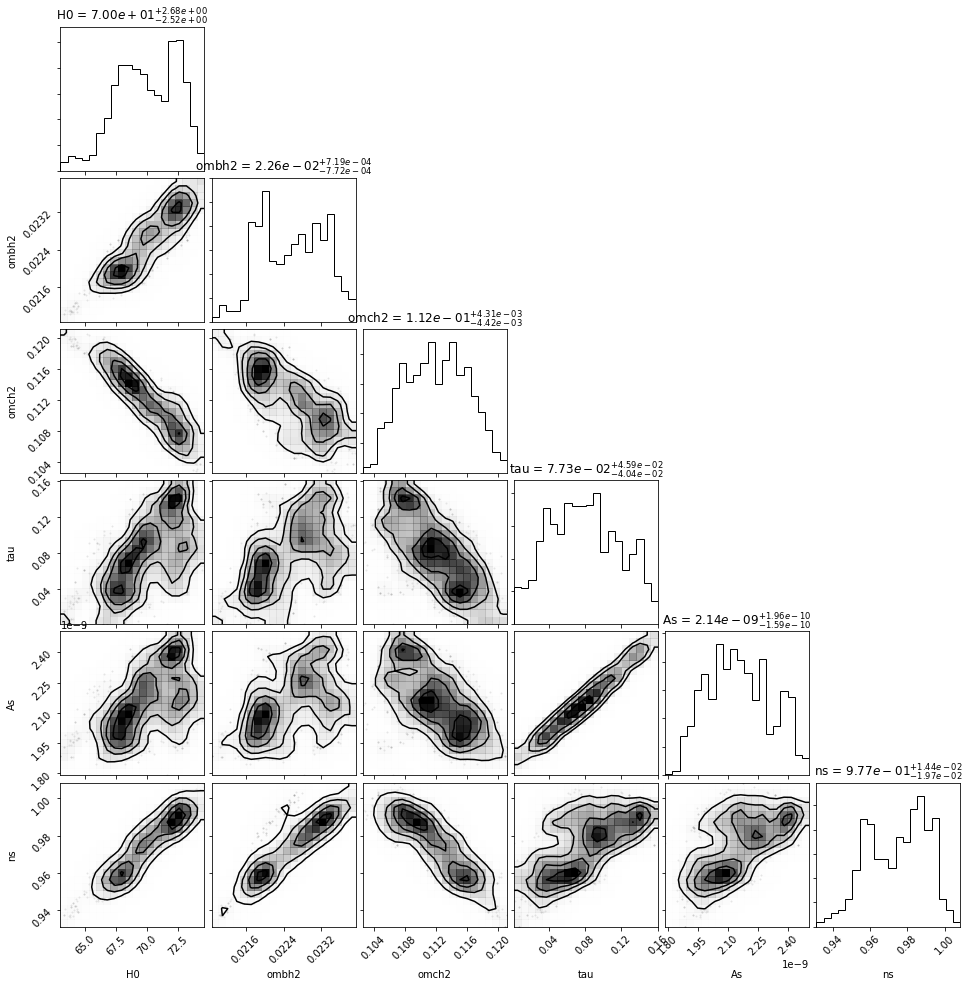

In [57]:
corner.corner(chains[n:], labels=['H0','ombh2','omch2','tau','As','ns'], show_titles=True, title_fmt='.2e', smooth=True)
plt.show()

### Problem 4

#### Method 1: Weight the result from 3 by the given prior for tau
Use the gaussian distribution $e^{-\dfrac{(\tau_i-\mu)^2}{2\sigma_i^2}} = e^{-\dfrac{(\tau-0.0544)^2}{2(0.0073)^2}}$ as a weighting factor to put more importance on samples that had a $\tau$ value in the range of the prior when taking the mean and standard deviation.

In [58]:
def weighted_mean(xi, wi):
    # xi = elements to find the weighted mean of
    # wi = weights for each element
    return np.sum(xi*wi)/np.sum(wi)

def weighted_std(xi, wi):
    return np.sqrt(np.sum(wi*(xi - weighted_mean(xi,wi))**2)/np.sum(wi))

In [59]:
# Take the chain from 3 and weight each parameter by a factor of exp(-0.5*((tau-0.0544)/0.0073)**2)
H0, ombh2, omch2, tau, As, ns = chains[n:].T # still excluding the beginning of the chain

# Calculate the weighted mean and standard deviation of each parameter for the Planck prior
weight_factor = np.exp(-0.5*((tau-0.0544)/0.0073)**2)

H0_weighted = weighted_mean(H0, weight_factor)
H0_weighted_std = weighted_std(H0, weight_factor)
ombh2_weighted = weighted_mean(ombh2, weight_factor)
ombh2_weighted_std = weighted_std(ombh2, weight_factor)
omch2_weighted = weighted_mean(omch2, weight_factor)
omch2_weighted_std = weighted_std(omch2, weight_factor)
tau_weighted = weighted_mean(tau, weight_factor)
tau_weighted_std = weighted_std(tau, weight_factor)
As_weighted = weighted_mean(As, weight_factor)
As_weighted_std = weighted_std(As, weight_factor)
ns_weighted = weighted_mean(ns, weight_factor)
ns_weighted_std = weighted_std(ns, weight_factor)

print('Results when weighting with the prior:')
print('H0 = '+repr(H0_weighted)+' +/- '+repr(H0_weighted_std))
print('ombh2 = '+repr(ombh2_weighted)+' +/- '+repr(ombh2_weighted_std))
print('omch2 = '+repr(omch2_weighted)+' +/- '+repr(omch2_weighted_std))
print('tau = '+repr(tau_weighted)+' +/- '+repr(tau_weighted_std))
print('As = '+repr(As_weighted)+' +/- '+repr(As_weighted_std))
print('ns = '+repr(ns_weighted)+' +/- '+repr(ns_weighted_std))

Results when weighting with the prior:
H0 = 69.01606330412248 +/- 2.2700093330612825
ombh2 = 0.0223614385208514 +/- 0.0006440209546611924
omch2 = 0.11403540729864796 +/- 0.0032665084519487584
tau = 0.05510992045835888 +/- 0.0075891065383888
As = 2.056723922486984e-09 +/- 3.367292926569207e-11
ns = 0.9676243948022535 +/- 0.014356744534295444


The parameters results when including a weighted prior are quite different from the results in 3 because $\tau$ did not stay close to the prior mean of 0.0544 in the Markov chain. The weights effectively reduce the size of the statistically relevant sample population (as seen in the plot of the weight factor against sample number below). Still, $\tau$ is now evaluated to be in the desired range based on the Planck prior, and the other parameters have been adjusted accordingly. Also, note that As and $\tau$ were both reduced similarly because they a heavily correlated.

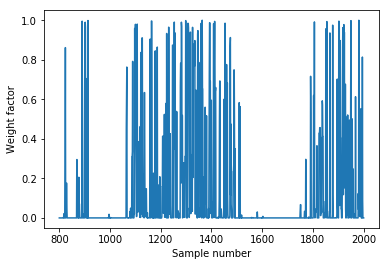

In [51]:
plt.plot(np.linspace(800,2000,1200), weight_factor)
plt.ylabel('Weight factor')
plt.xlabel('Sample number')
plt.show()

#### Method 2: Run a new chain with the added prior
Instead, it is likely a better idea to run a new chain from scratch, but now rewrite the likelihood as $\chi^2 = \sum_i \left(\dfrac{y_{\text{data},i} - y_{\text{model},i}}{\sigma_i}\right)^2 + \left(\dfrac{\tau_i - 0.0544}{0.0073}\right)^2$ to account for the prior while the chain is running. This should allow the MCMC to produce a much larger population of statistically relevant samples.

The new $\chi^2$ formula comes from the fact that the probability of two distributions is their product. So in log-space, like we have with $\chi^2$, the two must simply be added together.

In [69]:
# Start the chain from scratch
params = [65, 0.02, 0.1, 0.05, 2e-9, 0.96]
model_0 = get_spectrum(params, lmax)[2:]
# Use the new chi-squared that accounts for the prior
chisq = np.sum(((power_spectrum - model_0)/err)**2 + ((params[3] - 0.0544)/0.0073)**2)

# MCMC settings
nstep = 2000
chains_prior = np.zeros([nstep, len(params)])
chisqvec_prior = np.zeros(nstep)
scale_fac = 0.2 # gives an acceptance ratio of ~20%

c = 0
with open('logfile6.txt', 'w') as f:
    f.write('Step\tH0\t\t\t\t\tombh2\t\t\t\tomch2\t\t\t\ttau\t\t\t\t\tAs\t\t\t\t\tns\t\t\t\t\tNewChi2\t\t\t\tDeltaChi2\t\t\tProb\t\t\t\tAccept\n')
    while c < nstep:
        # Sample a new set of parameters using the covariance matrix from 2 for a free tau
        new_params = params + take_step_cov(mycov)*scale_fac
        # If a negative tau is sampled, resample.
        if new_params[3] < 0:
            continue
        try:
            new_model = get_spectrum(new_params, lmax)[2:]
            new_chisq = np.sum(((power_spectrum-new_model)/err)**2 + ((new_params[3] - 0.0544)/0.0073)**2) # new chi-squared accounts for the prior
            delta_chisq = new_chisq - chisq
            prob = np.exp(-delta_chisq/2)
            accept = np.random.rand() < prob
            if accept:
                f.write('{:00005d}\t{:.10e}\t{:.10e}\t{:.10e}\t{:.10e}\t{:.10e}\t{:.10e}\t{:.10e}\t{:.10e}\t{:.10e}\t{:d}\n'.format(c+1,new_params[0],new_params[1],new_params[2],new_params[3],new_params[4],new_params[5],new_chisq,delta_chisq,prob,1))
                params = new_params
                model = new_model
                chisq = new_chisq
            else:
                f.write('{:00005d}\t{:.10e}\t{:.10e}\t{:.10e}\t{:.10e}\t{:.10e}\t{:.10e}\t{:.10e}\t{:.10e}\t{:.10e}\t{:d}\n'.format(c+1,new_params[0],new_params[1],new_params[2],new_params[3],new_params[4],new_params[5],new_chisq,delta_chisq,prob,0))
            chains_prior[c,:] = params
            chisqvec_prior[c] = chisq
            c = c + 1
            f.flush()
        except:
            continue

Final chi-squared = 1527.0386712604159


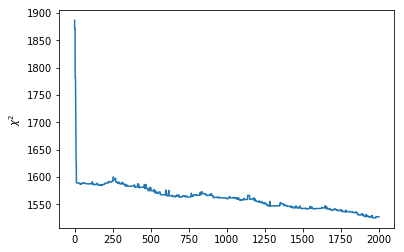

In [70]:
# Take a look at the chi-squared evolution
print('Final chi-squared = '+repr(chisqvec_prior[-1]))
plt.plot(chisqvec_prior)
plt.ylabel(r'$\chi^2$')
plt.show()

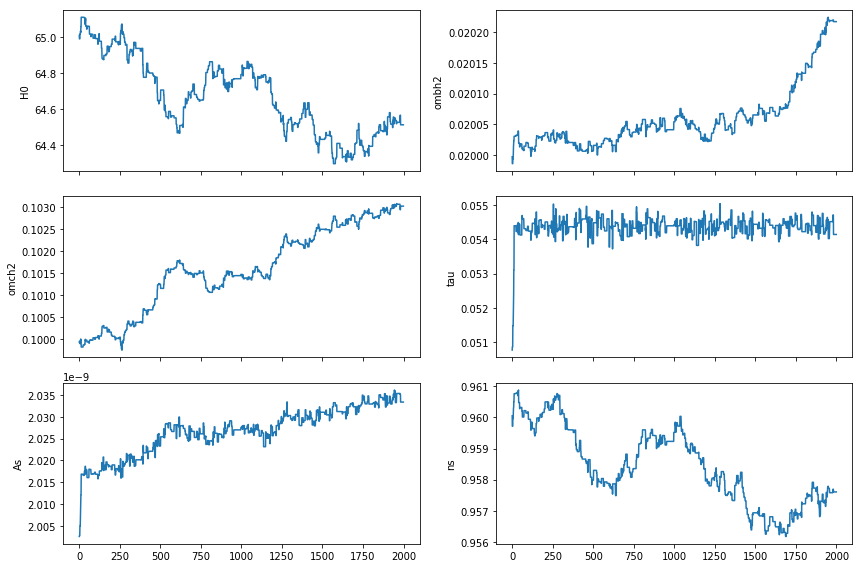

In [71]:
# Take a look at the Markov chain
f, axes = plt.subplots(3, 2, sharex=True, figsize=(12,8))

axes[0,0].plot(chains_prior[:,0])
axes[0,1].plot(chains_prior[:,1])
axes[1,0].plot(chains_prior[:,2])
axes[1,1].plot(chains_prior[:,3])
axes[2,0].plot(chains_prior[:,4])
axes[2,1].plot(chains_prior[:,5])

axes[0,0].set_ylabel('H0')
axes[0,1].set_ylabel('ombh2')
axes[1,0].set_ylabel('omch2')
axes[1,1].set_ylabel('tau')
axes[2,0].set_ylabel('As')
axes[2,1].set_ylabel('ns')
plt.tight_layout()
plt.show()

The parameters have still not converged, much like in the full chain from problem 3. However, $\tau$ appears to be converged, but this is because its selection was forced to stay close to the prior value of $\tau=0.054\pm0.0073$. As demonstrated in a plot above, the $\chi^2$ is still slowly but steadily decreasing in this MCMC run. Also, I had to use a scale the step size down for this run to increase the acceptance ratio to roughly 20%, but this unfortunately slows the convergence of the chain. So, more samples are likely necessary for more accurate results. Nonetheless, there are some differences between the two chains that are immediately obvious. For example, some of the parameters are going in opposing directions (H0, ns), and As and tau do not appear to be closely correlated as they were before. The first difference could simply be an artifact of taking much smaller steps but keeping the same number of samples. On the other hand, ombh2, omch2, and As are all trending towards the same values as earlier, just very slowly. This is extra evidence for the need for more samples.

Let's take a look at where the parameters ended up (using the last half of the samples).

In [89]:
n = 1000
print('H0 = '+repr(np.mean(chains_prior[n:,0]))+' +/- '+repr(np.std(chains_prior[n:,0])))
print('ombh2 = '+repr(np.mean(chains_prior[n:,1]))+' +/- '+repr(np.std(chains_prior[n:,1])))
print('omch2 = '+repr(np.mean(chains_prior[n:,2]))+' +/- '+repr(np.std(chains_prior[n:,2])))
print('tau = '+repr(np.mean(chains_prior[n:,3]))+' +/- '+repr(np.std(chains_prior[n:,3])))
print('As = '+repr(np.mean(chains_prior[n:,4]))+' +/- '+repr(np.std(chains_prior[n:,4])))
print('ns = '+repr(np.mean(chains_prior[n:,5]))+' +/- '+repr(np.std(chains_prior[n:,5])))

H0 = 64.52958972884436 +/- 0.14740580729608138
ombh2 = 0.02008806047028562 +/- 5.5079595502054697e-05
omch2 = 0.1023289361310313 +/- 0.000528375982800378
tau = 0.05437257185581836 +/- 0.00020040042261910873
As = 2.030498802499476e-09 +/- 2.8204647008071103e-12
ns = 0.9576149225520364 +/- 0.0009181253265536116


These results are quite different from the results obtained in the previous full chain and from the weighted results.

Finally, the corner plot for the new chain confirms that the parameters do not appear to be correlated in the same way either once the prior is included into a chain. It shows that As and tau are no longer strongly correlated, while some new correlation exists H0 and ns.

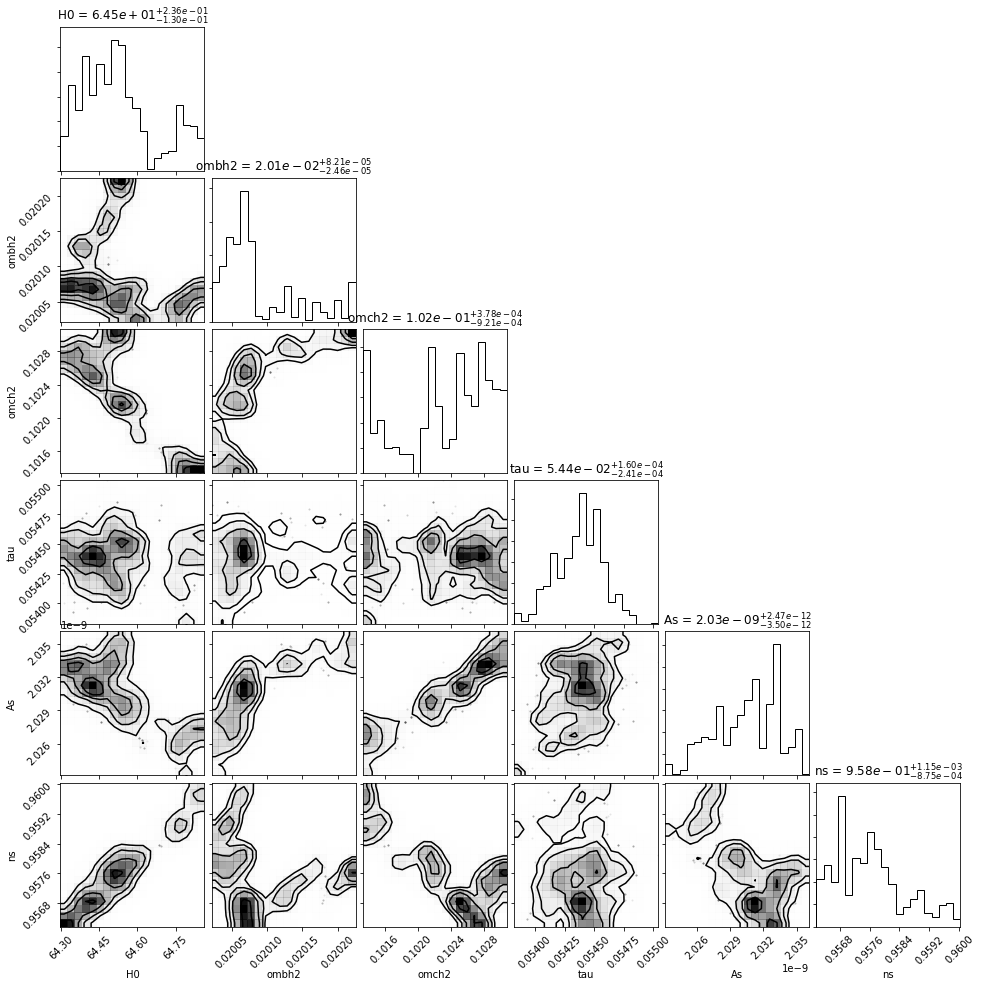

In [92]:
corner.corner(chains_prior[1000:], labels=['H0','ombh2','omch2','tau','As','ns'], show_titles=True, title_fmt='.2e', smooth=True)
plt.show()